### 폐렴 사진 분류
필요 라이브러리 import

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from glob import glob
from keras import layers, models
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

### 데이터 분포 확인
각 세트 별 데이터 분포에 대해서 확인합니다.

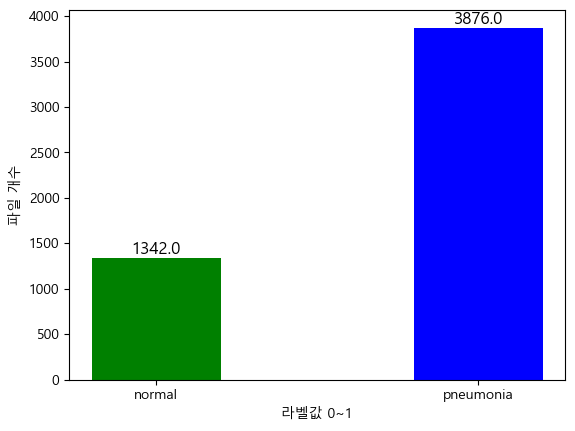

In [2]:
mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob("./chest_xray/train/*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ["normal", "pneumonia"] # 라벨값

bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue"]) # barplot
plt.xlabel("라벨값 0~1")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
plt.show()

### 라벨값 간 불균형 해소
각 라벨값간 개수의 불균형을 해소하기 위해서 폐렴 사진의 일부를 삭제한다.

In [3]:
origin_path = "./chest_xray/train/PNEUMONIA/"
pneumonia = os.listdir(origin_path)

for i in range(2534):
    os.remove(origin_path + pneumonia[i])

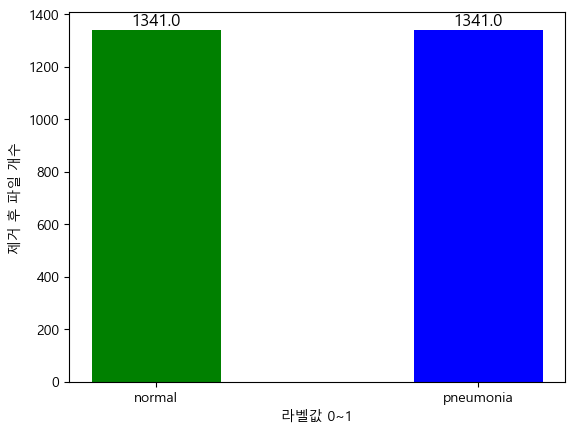

In [2]:
mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob("./chest_xray/train/*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ["normal", "pneumonia"] # 라벨값

bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue"]) # barplot
plt.xlabel("라벨값 0~1")
plt.ylabel("제거 후 파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
plt.show()

### 하이퍼 파라미터 정의
모델에 사용할 하이퍼 파라미터를 정의합니다.

In [3]:
num_epoch = 100             # 훈련 횟수
batch_size = 16             # 데이터 묶음 단위수
learning_rate = 0.0001      # 학습률
dropout_rate = 0.2          # dropout 비율
input_shape = (224, 224, 1) # 입력 이미지 크기
num_class = 2               # 분류 클래스 수

### 이미지 증강처리
데이터 학습 시, 변형 및 증강된 이미지로 학습하기 위해 증강기를 정의합니다.

In [16]:
train_dir = './chest_xray//train/'
test_dir = "./chest_xray/test/"

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range = 90,
    width_shift_range = 0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = input_shape[:2],
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode='binary'
)                                   

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],    
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
) 

Found 2682 images belonging to 2 classes.
Found 620 images belonging to 2 classes.


### 학습 모델(직접 설계 vs 전이학습)
직접 모델층을 구성하여 진행하는 과정과, 전이 학습하는 결과를 비교합니다.

In [18]:
# 직접 빌드
def create_my_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape = input_shape))
    model.add(layers.MaxPooling2D(2, 2)) # stride를 지정하지 않을 경우, 커널 사이즈로 자동 지정됨. = 2칸씩 건너뛰며 MaxPooling 수행
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten()) # 완전연결층의 입력층 부분
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid")) 

    return model

# 훈련
def fit_my_cnn():
    model = create_my_cnn()
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=['acc'])

    # Gradient Clipping : 기울기의 값이 지나치게 커지면서 폭발하는 기울기 폭발(폭주) 문제를 막기 위해서 tf.optimizers.Adam(learning_rate)과 같은 optimizer를 이용한다. 
    # 기울기를 자른다는 의미에서 알 수 있듯, 기울기에 대한 임계치를 정한다.

    # 콜백함수 정의
    model_check = ModelCheckpoint(filepath = "./model/weights/7th_train.h5", monitor = "val_acc", save_best_only = True, mode = "max")
    reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 3, mode = "min") # 지표(val_loss) 개선이 미미하면 학습률에 factor를 곱해 학습률을 감소시킵니다.
    early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    logger = CSVLogger('./model/6th_train.csv')

    call_back_list = [model_check, reduce_lr, early_stop, logger]

    # 학습
    model.fit(train_generator, epochs = num_epoch, validation_data = validation_generator, callbacks = call_back_list)

# 학습 추이 시각화
def show_history(history_csv_path):               # history csv 경로를 입력받고
    mlp.rcParams["font.family"] = "Malgun Gothic" # 그래프 내부에 한글 깨짐 방지 처리
    mlp.rcParams["axes.unicode_minus"] = False    # 그래프 축 상에 마이너스 부호 깨짐 방지
    
    history = pd.read_csv(history_csv_path)       # 히스토리 csv파일을 읽어온다.
    plt.figure(figsize=(10,5))                    # 그래프 크기 지정

    # 1행 2열 중, 1열의 공간을 생성함
    plt.subplot(1, 2, 1)
    plt.plot(history["epoch"], history['acc'], label="train_accuracy")     # 학습 정확도에 대한 그래프
    plt.plot(history["epoch"], history['val_acc'], label="valid_accuracy") # 검증 정확도에 대한 그래프
    plt.title('모델 정확도') # 그래프의 타이틀 설정
    plt.xlabel('학습 횟수') # x축 이름 설정
    plt.ylabel("정확도") # y축 이름 설정
    plt.legend()

    # 1행 2열 중, 2열의 공간을 생성함
    plt.subplot(1, 2, 2)
    plt.plot(history["epoch"], history['loss'], label="train_loss_value")     # 손실값에 대한 그래프
    plt.plot(history["epoch"], history['val_loss'], label="valid_loss_value") # 검증 손실값에 대한 그래프
    plt.title('모델 손실값')
    plt.xlabel('학습 횟수')
    plt.ylabel("손실값")
    plt.legend()
    plt.show()

Epoch 1/100
168/168 [==============================] - 20s 117ms/step - loss: 0.6772 - acc: 0.5764 - val_loss: 0.6173 - val_acc: 0.6613 - lr: 1.0000e-04
Epoch 2/100
168/168 [==============================] - 19s 114ms/step - loss: 0.5084 - acc: 0.7744 - val_loss: 0.3802 - val_acc: 0.8403 - lr: 1.0000e-04
Epoch 3/100
168/168 [==============================] - 20s 116ms/step - loss: 0.4202 - acc: 0.8121 - val_loss: 0.3364 - val_acc: 0.8581 - lr: 1.0000e-04
Epoch 4/100
168/168 [==============================] - 20s 116ms/step - loss: 0.3541 - acc: 0.8576 - val_loss: 0.3275 - val_acc: 0.8452 - lr: 1.0000e-04
Epoch 5/100
168/168 [==============================] - 20s 118ms/step - loss: 0.3598 - acc: 0.8561 - val_loss: 0.3398 - val_acc: 0.8484 - lr: 1.0000e-04
Epoch 6/100
168/168 [==============================] - 20s 118ms/step - loss: 0.3467 - acc: 0.8602 - val_loss: 0.3259 - val_acc: 0.8500 - lr: 1.0000e-04
Epoch 7/100
168/168 [==============================] - 20s 119ms/step - loss: 0.33

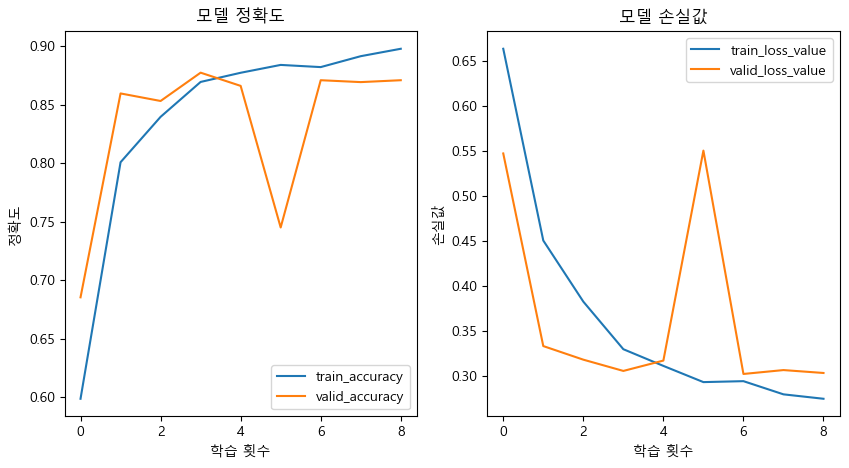

In [19]:
fit_my_cnn()
show_history('./model/6th_train.csv')

In [26]:
test_generator = test_datagen.flow_from_directory(
    "./chest_xray/val/",
    target_size=input_shape[:2],    
    color_mode='grayscale',
    class_mode='binary'
)

y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

Found 16 images belonging to 2 classes.


In [27]:
models1 = load_model("./model/weights/weights.08-0.27.h5")
predictions = models1.predict(test_generator, verbose=0)
y_pred = []

for val in predictions:
    if val > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.50      0.62      0.56         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.49        16
weighted avg       0.50      0.50      0.49        16



In [28]:
models2 = load_model("./model/weights/modify.15-0.31.h5")
y_pred2 = []

predictions2 = models2.predict(test_generator, verbose=0)
for val in predictions2:
    if val > 0.5:
        y_pred2.append(1)
    else:
        y_pred2.append(0)
        
print(classification_report(y_true, y_pred2))

              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.44      0.50      0.47         8

    accuracy                           0.44        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.44      0.44      0.44        16



In [29]:
models3 = load_model("./model/weights/rotation_90_64batch.13-0.32.h5")
y_pred3 = []

predictions3 = models3.predict(test_generator, verbose=0)
for val in predictions3:
    if val > 0.5:
        y_pred3.append(1)
    else:
        y_pred3.append(0)
        
print(classification_report(y_true, y_pred3))

              precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.36      0.50      0.42         8

    accuracy                           0.31        16
   macro avg       0.28      0.31      0.29        16
weighted avg       0.28      0.31      0.29        16



In [30]:
models4 = load_model("./model/weights/del_shift_32batch.04-0.32.h5")
y_pred4 = []

predictions4 = models4.predict(test_generator, verbose=0)
for val in predictions4:
    if val > 0.5:
        y_pred4.append(1)
    else:
        y_pred4.append(0)
        
print(classification_report(y_true, y_pred4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      0.62      0.48         8

    accuracy                           0.31        16
   macro avg       0.19      0.31      0.24        16
weighted avg       0.19      0.31      0.24        16



In [31]:
models5 = load_model("./model/weights/5th_train.h5")
y_pred5 = []

predictions5 = models5.predict(test_generator, verbose=0)
for val in predictions5:
    if val > 0.5:
        y_pred5.append(1)
    else:
        y_pred5.append(0)
        
print(classification_report(y_true, y_pred5))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.70      0.88      0.78         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



In [32]:
models6 = load_model("./model/weights/6th_train.h5")
y_pred6 = []

predictions6 = models6.predict(test_generator, verbose=0)
for val in predictions6:
    if val > 0.5:
        y_pred6.append(1)
    else:
        y_pred6.append(0)
        
print(classification_report(y_true, y_pred6))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



### 모델 튜닝(전이 학습, 생성기 수정, 미세 조정)
VGG19로 전이학습을 진행합니다. 그 이전에 생성기와 몇 파라미터를 수정하고, 전이학습에 미세조정을 병행합니다.

전이학습은 경우에 따라 미세조정(Fine tuning)과 같은 의미로 사용되기도 하지만, 특성추출과 미세조정 2가지로 세분화하여 1단계에서는 특성추출을 사용하고, 2단계에서 미세조정을 진행했습니다. 특성추출은 컨볼루션층의 파라미터는 고정시키고 완전연결층의 파라미터를 재학습시키는 것을 의미하고, 미세조정은 완전연결층과 더불어 컨볼루션층의 마지막 몇 개층 파라미터를 재학습시키는 것을 의미한다

In [15]:
input_shape = (224, 224, 3) # 150, 224
batch_size = 32 # 4, 8

# 생성기 수정 시도
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.densenet.preprocess_input, # 0 ~ 1사이 값으로 조정하되, 각 채널은 ImageNet 데이터 세트에 대해 정규화
    width_shift_range=0.3,               
    zoom_range=0.2,                      
    horizontal_flip=True,
    fill_mode = 'nearest',
    shear_range = 0.2               
)

test_datagen = ImageDataGenerator(      
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
)

train_generator = train_datagen.flow_from_directory( 
    train_dir,                 
    target_size = input_shape[:2],  
    batch_size = batch_size,      
    color_mode = 'rgb',           
    class_mode='binary'        
)                                   

validation_generator = test_datagen.flow_from_directory(
    test_dir,                      
    target_size=input_shape[:2],    
    batch_size=batch_size,          
    color_mode='rgb',
    class_mode='binary'        
)

def get_model(model):
    
    params = {'input_shape' : input_shape, 
              'include_top': False,  # Affine 계층을 포함시키지 않고 직접 구현하여 연결한다.
              'weights':'imagenet', # imagenet의 가중치 사용
              'pooling':'max',
              'classes':2}
    
    pretrained_model = model(**params) # **는 dictionary(params)내부의 키:값 쌍을 함수에 keyword 인자(input_shape = input_shape)로 전달합니다.
    
    for pretrained_layer in pretrained_model.layers[:23]: # 본래 미세 조정의 의미는 Affine 계층의 하이퍼 파라미터를 재학습함과 더불어 사전 학습 모델의 최상단의 일부를 재학습 하는 것을 의미하나
        pretrained_layer.trainable = False # 딱히 의미가 없어 그냥 전부 동결시켰습니다.
    
    inputs = pretrained_model.input
    
    # 완전연결신경망 구축(functional api method)
    x = tf.keras.layers.Flatten()(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])
    
    return model

def fit_vgg19():
    model_check = ModelCheckpoint(filepath = "./model/VGG19/weights/weights.{epoch:02d}-{val_loss:.2f}.h5", monitor = "val_loss", save_best_only = True, mode = "min")
    reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 3, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    logger = CSVLogger('./model/VGG19/VGG19_history.csv')
    
    model = get_model(tf.keras.applications.VGG19)
    model.fit(train_generator, epochs = num_epoch, steps_per_epoch = len(train_generator),
              validation_data = validation_generator, validation_steps = len(validation_generator),
              callbacks=[model_check, reduce_lr, early_stop, logger])

Found 2682 images belonging to 2 classes.
Found 620 images belonging to 2 classes.


Epoch 1/100
84/84 [==============================] - 45s 480ms/step - loss: 0.3767 - acc: 0.8315 - val_loss: 0.2889 - val_acc: 0.8774 - lr: 0.0010
Epoch 2/100
84/84 [==============================] - 36s 422ms/step - loss: 0.2233 - acc: 0.9075 - val_loss: 0.2874 - val_acc: 0.8742 - lr: 0.0010
Epoch 3/100
84/84 [==============================] - 37s 438ms/step - loss: 0.2050 - acc: 0.9146 - val_loss: 0.5229 - val_acc: 0.7968 - lr: 0.0010
Epoch 4/100
84/84 [==============================] - 37s 440ms/step - loss: 0.1906 - acc: 0.9306 - val_loss: 0.2733 - val_acc: 0.8919 - lr: 0.0010
Epoch 5/100
84/84 [==============================] - 37s 442ms/step - loss: 0.1852 - acc: 0.9258 - val_loss: 0.2517 - val_acc: 0.9032 - lr: 0.0010
Epoch 6/100
84/84 [==============================] - 37s 441ms/step - loss: 0.1621 - acc: 0.9370 - val_loss: 0.2590 - val_acc: 0.9048 - lr: 0.0010
Epoch 7/100
84/84 [==============================] - 37s 437ms/step - loss: 0.1581 - acc: 0.9336 - val_loss: 0.2781 - 

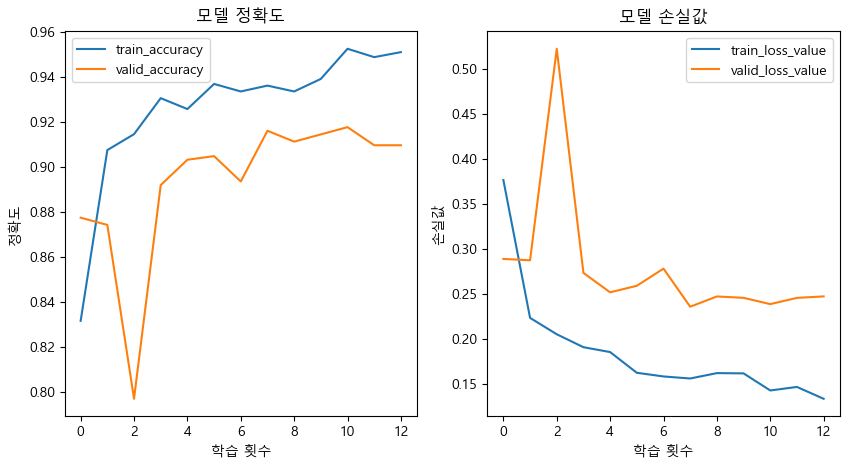

In [16]:
fit_vgg19()
show_history('./model/VGG19/VGG19_history.csv')

In [18]:
vgg_model = load_model("./model/VGG19/weights/weights.08-0.24.h5")

In [19]:
validation_generator = test_datagen.flow_from_directory(
    "./chest_xray/val/",
    target_size=input_shape[:2],    
    batch_size=batch_size,          
    color_mode='rgb',
    class_mode='binary' 
)

Found 16 images belonging to 2 classes.


In [21]:
predictions = vgg_model.predict(validation_generator, verbose=0)
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
y_pred = []

for val in predictions:
    if val > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.57      0.50      0.53         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16

